# HW4 Transformer is all you need

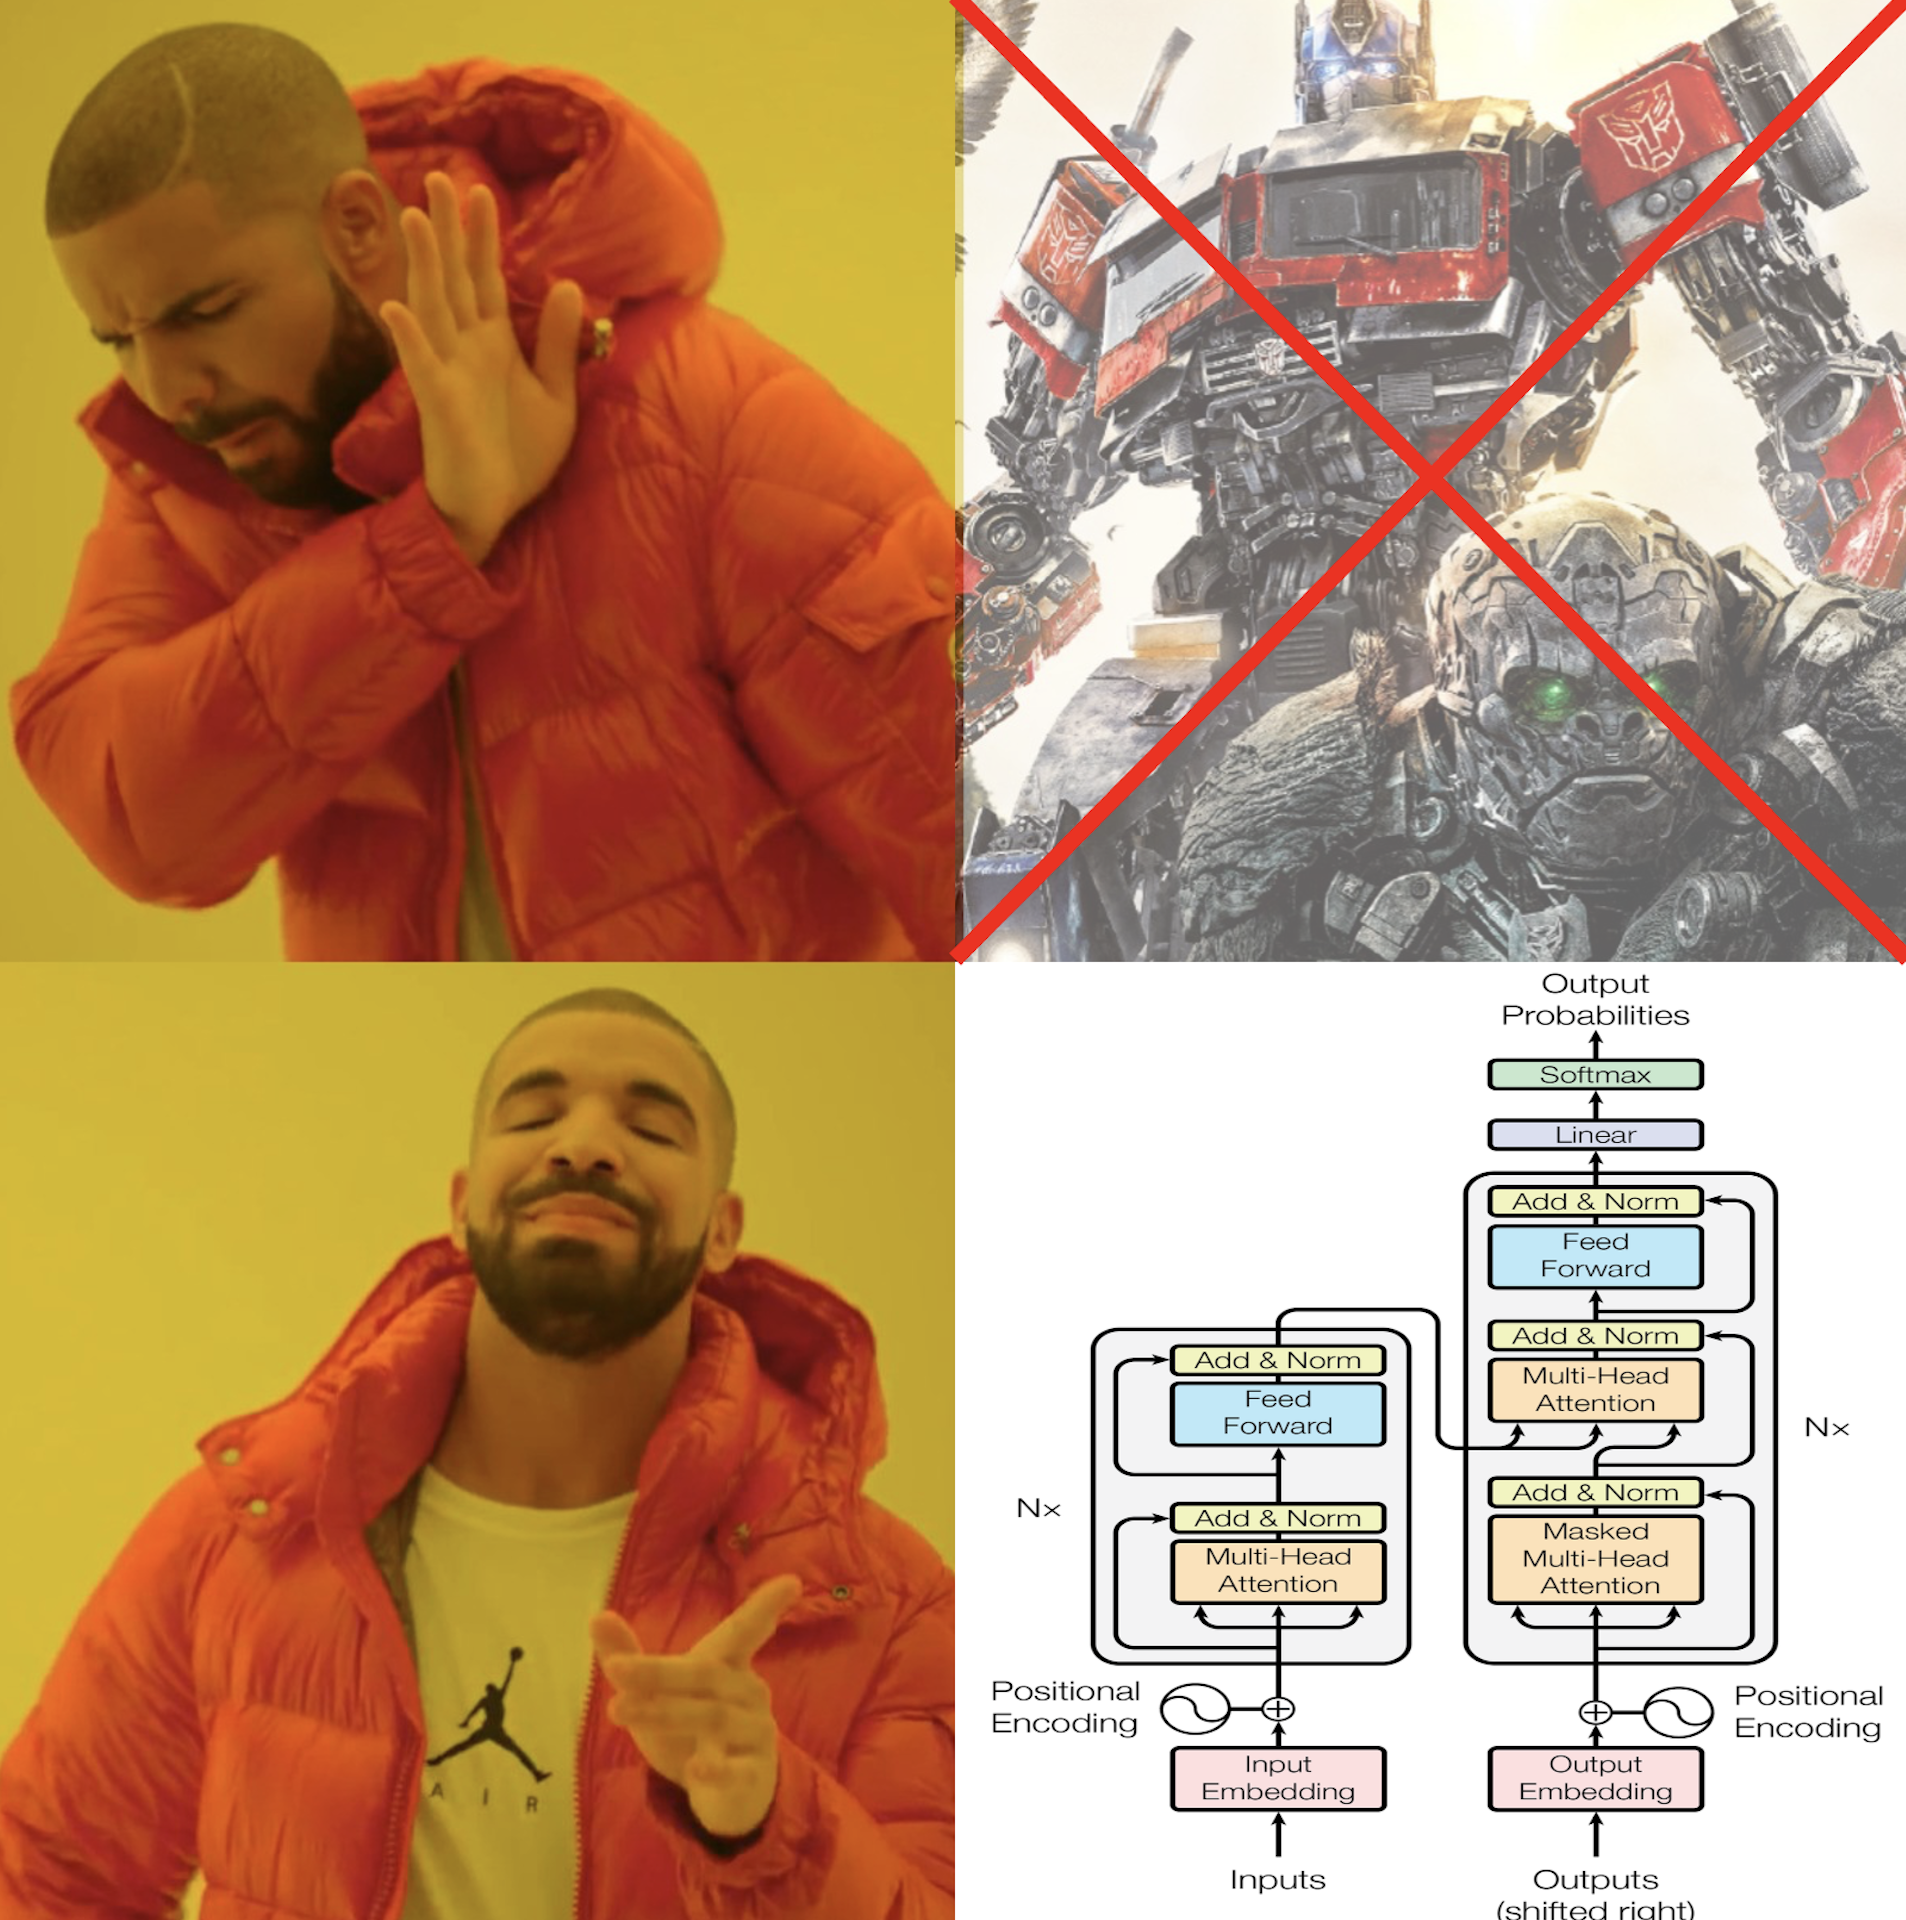

Transformer is a groundbreaking deep learning architecture introduced in the seminal paper "Attention is All You Need" by Vaswani et al. in 2017 (https://arxiv.org/abs/1706.03762). This architecture has revolutionized the fields of natural language processing (NLP) and computer vision by enabling models to handle sequential data efficiently and capture long-range dependencies better than traditional architectures such as recurrent neural networks (RNNs) and convolutional neural networks (CNNs). Some seminal work: [OpenAI's GPT](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) and [Meta's Segment Anything Model](https://arxiv.org/abs/2304.02643) build their architecture with Transformers.

For NLP tasks, input texts are partitioned into sequences of tokens, which are then transformed into word embeddings.
For computer vision tasks, input images are divided into sub-grids, which are converted into image tokens.

Transformers excel by directly modeling the relationships between tokens using self-attention, a mechanism that dynamically determines how information flows between tokens. Unlike CNNs, Transformers capture relationships between tokens without regard to their pairwise distance, making them exceptionally effective for tasks requiring global context.

In this assignment, you will:

**HW4_P1P2.ipynb**
1. Problem 1: Implement multi-head attention from scratch using PyTorch. This will give you a solid understanding of how attention mechanisms operate.
2. Problem 2: Use your implemented multi-head self-attention to build a Transformer encoder from scratch. You will then fine-tune a BERT model for a simple NLP task: sequence classification.

**HW4_P3.ipynb**
3. Problem 3: Explore the versatility of Transformers by using Hugging Face’s Vision Transformer (ViT) for image classification.

Please compress the finished HW4_P1P2.ipynb and HW4_P3.ipynb into a zip file and upload to the course Canvas.

By completing these exercises, you will gain hands-on experience with the architecture of Transformers and develop an appreciation for their remarkable ability to model the world, as seen in systems like ChatGPT.

Now, have fun and enjoy building your own Transformer! 🚀




## P1 Attention is all you need

In problem 1, we will impelemnt attention pytorch modules based on the introduction in the [Attention is all you need paper](https://arxiv.org/abs/1706.03762). Please read the paper before you work on problem 1. It is also strongly encouraged to reference this [Python notebook](https://nlp.seas.harvard.edu/annotated-transformer/).

What is attention?

Attention determines the relevance of different elements (tokens, pixels, etc.) in the input to a given task or query. Instead of processing all input elements equally, the attention mechanism assigns different weights to different parts, helping the model prioritize the most important information.

In this assignment, we are going to implement the scaled dot product attention.


$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$


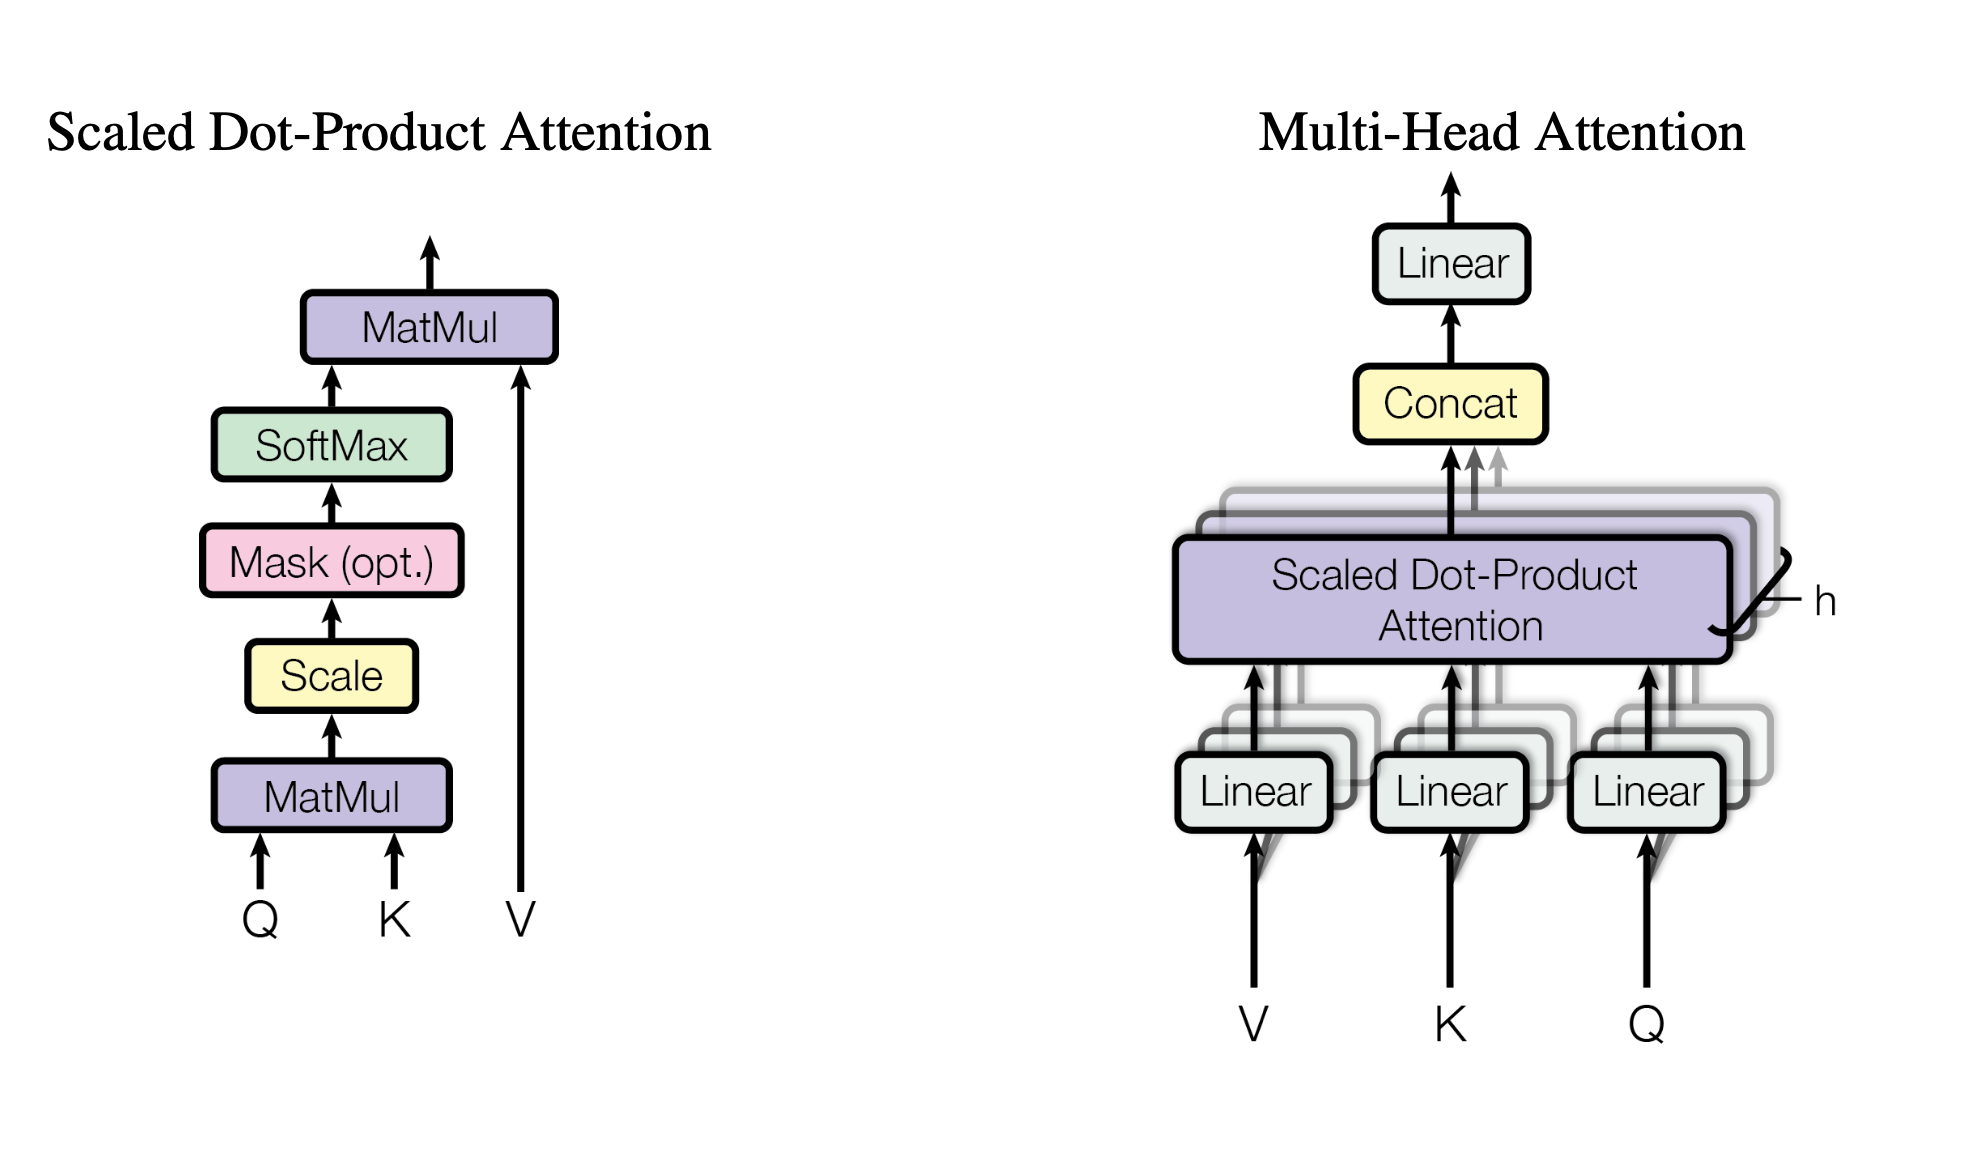

Introduction to Multi-Head Attention Steps

Multi-head attention is a key mechanism in Transformer models, enabling the model to focus on different parts of the input sequence simultaneously. It computes relationships between tokens using queries ($Q$), keys ($K$), and values ($V$), and splits these computations across multiple attention heads for diverse context capturing. Here's a brief overview of the process:

1. **Initialization**: Set up linear layers to compute $Q$, $K$, $V$, and an output layer, along with dropout for regularization.
2. **Input Dimensions**: Define batch size, sequence length, and optionally use a mask to restrict attention to specific tokens.
3. **Linear Transformations**: Project the input embeddings into $Q$, $K$, and $V$ spaces through learned weight matrices.
4. **Splitting into Heads**: Divide the embeddings into multiple smaller subspaces (one per head) to allow parallel attention computation.
5. **Scaled Dot-Product Attention**: Compute attention scores by taking the dot product of $Q$ and $K^T$, scaled by $\sqrt{d_k}$.
6. **Masking**: Apply a mask to ignore padding or restrict future token access for causal attention.
7. **Softmax Normalization**: Normalize attention scores into probabilities using the softmax function.
8. **Weighted Sum**: Multiply attention probabilities with $V$ to compute context-aware token representations.
9. **Combining Heads**: Concatenate outputs from all heads and reshape into the original hidden size.
10. **Final Projection**: Pass the combined output through a final linear layer to integrate the information from all heads.

You are going to follow the above steps to implement Multi-Head Attention.


In [1]:
import torch
import torch.nn as nn

# Implement Multi-Head Attention
class Attention(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout_prob):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        # Assumes q, k and v have the same dimension
        # Model initialization
        self.linear_q = nn.Linear(hidden_size, hidden_size)
        self.linear_k = nn.Linear(hidden_size, hidden_size)
        self.linear_v = nn.Linear(hidden_size, hidden_size)
        self.linear_out = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, hidden_states, mask=None, return_attention_weight=False):
        # hidden_states: [batch_size, seq_len, hidden_size]
        attention_weight = None # [batch_size, num_heads, seq_len, seq_len]
        # TODO: Please implement the forward function

        # 1. Linear Transformations
        batch_size, seq_len, hidden_size = hidden_states.size()
        Q = self.linear_q(hidden_states)  # (batch_size, seq_len, hidden_size)
        K = self.linear_k(hidden_states)  # (batch_size, seq_len, hidden_size)
        V = self.linear_v(hidden_states)  # (batch_size, seq_len, hidden_size)

        # 2. Split the hidden_states into num_heads
        head_dim = hidden_size // self.num_heads
        Q = Q.view(batch_size, seq_len, self.num_heads, head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        K = K.view(batch_size, seq_len, self.num_heads, head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, head_dim).transpose(1, 2)

        # 3. Calculate the attention score
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (head_dim ** 0.5)

        # 4. Apply the mask
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)
            # attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        # 5. Apply the softmax
        attention_weight = torch.softmax(attention_scores, dim=-1)

        # 6. Apply the dropout
        attention_weight = self.dropout(attention_weight)

        # 7. Apply the weighted sum of the values
        attention_output = torch.matmul(attention_weight, V)  # (batch_size, num_heads, seq_len, head_dim)

        # 8. Concatenate hidden_states from different heads
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, seq_len, hidden_size)

        # 9. Apply the final linear transformation
        output = self.linear_out(attention_output)

        if return_attention_weight:
            return output, attention_weight
        return output



torch.Size([1, 10, 512])


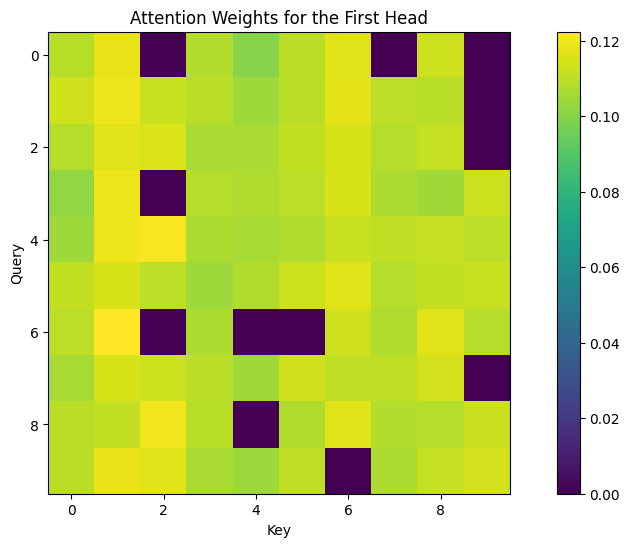

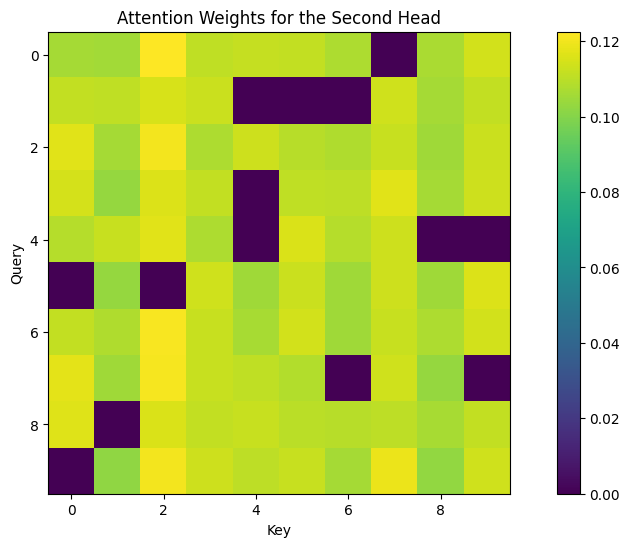

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Now, let's test the implementation
hidden_size = 512
num_heads = 8
dropout_prob = 0.1
attention = Attention(hidden_size, num_heads, dropout_prob)
batch_size = 1
seq_len = 10
hidden_states = torch.rand(batch_size, seq_len, hidden_size)

# output = attention(hidden_states)
output, attention_weights = attention(hidden_states, return_attention_weight=True)

print(output.shape) # Expected output: [batch_size, seq_len, hidden_size]

# TODO: visualize the first head's attention weight matrix using plt
first_attention_weight = attention_weights[0, 0].detach().cpu().numpy() # first head's attention weight
plt.figure(figsize=(12, 6))
plt.imshow(first_attention_weight)
plt.title("Attention Weights for the First Head")
plt.xlabel("Key")
plt.ylabel("Query")
plt.colorbar()
plt.show()


# TODO: visualize the second head's attention weight matrix using plt
second_attention_weight = attention_weights[0, 1].detach().cpu().numpy() # second head's attention weight
plt.figure(figsize=(12, 6))
plt.imshow(second_attention_weight)
plt.title("Attention Weights for the Second Head")
plt.xlabel("Key")
plt.ylabel("Query")
plt.colorbar()
plt.show()

In auto regressive language model, like GPT, we want to restrict the current hidden state attends only to hidden states in the past, because every time the model generates a new word or token, it's conditioned on the words it has generated. We call this type of attention, causal attention. Please implement the causal attention mechanism using masking.

torch.Size([1, 10, 512])


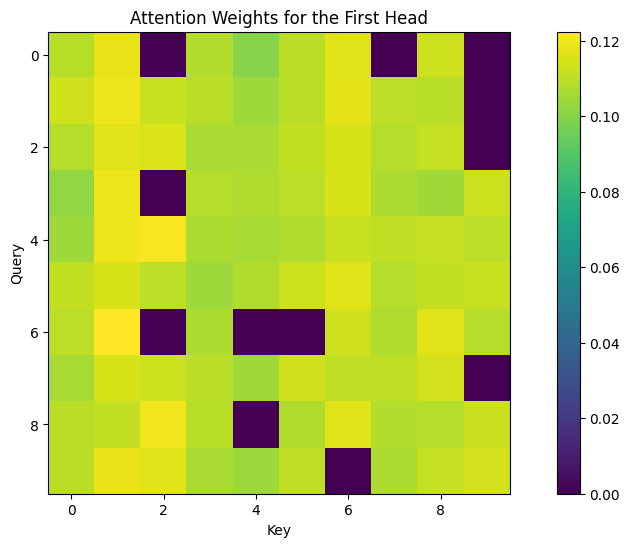

In [3]:
# Now, let's test the implementation
hidden_size = 512
num_heads = 8
dropout_prob = 0.1
attention = Attention(hidden_size, num_heads, dropout_prob)
batch_size = 1
seq_len = 10
hidden_states = torch.rand(batch_size, seq_len, hidden_size)
# TODO: Implement the causl attention layer using masking
# upper-triangular set to -inf
mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
mask = mask.unsqueeze(0).unsqueeze(1) # [1, 1, seq_len, seq_len]
output, attention_weight = attention(hidden_states, mask, return_attention_weight=True)

# mask = None
# output, attention_weight = attention(hidden_states, mask, return_attention_weight=True)
print(output.shape) # Expected output: [batch_size, seq_len, hidden_size]

# TODO: visualize first head's attention weight to see if the model is actually attending to the past tokens
first_attention_weight = attention_weights[0, 0].detach().cpu().numpy() # first head's attention weight
plt.figure(figsize=(12, 6))
plt.imshow(first_attention_weight)
plt.title("Attention Weights for the First Head")
plt.xlabel("Key")
plt.ylabel("Query")
plt.colorbar()
plt.show()

**Answer the following questions:**

Q: Why is the dot product of \(Q\) and \(K\) scaled by the square root of the key dimension?

**Answer**:  in order to prevent softmax saturation and maintain stable gradients during training.


Q: Given a query and key of sequence length \(N\), what is the computational complexity of attention using Big O Notation?

**Answer**:  O((N^2)*dk), where dk denotes the queries and keys of dimension


Q: Given an input sequence of \(N\), if we apply a convolutional filter with kernel size \(M\), what is the computational complexity using Big O Notation?

**Answer**: O(N*M)


Q: Based on this finding, we know that CNNs are more memory and speed efficient. What are the possible solutions to handle long input sequences in Attention? Please provide at least one solution.  
*(Hint: one possible solution is to think about masking.)*

**Answer**:  Use sparse attention technique. It reduces complexity by computing attention for only a subset of token pairs and focus on relevant positions


**Q: Why do we partition hidden states along the feature dimension and aggregate them by multi-head attention instead of using a single head attention? Can you find multi-head attention analogy to group convolution?**

**Answer**:  Partitioning allows the model to capture diverse relationships and patterns from different perspectives, as each head learns separate aspects of the sequence. Similar to how group convolution splits filters to capture different spatial features, multi-head attention divides the hidden features so each head can focus on different parts of the data, making the model faster and better at learning diverse patterns.


Besides dot product attention, can you list three more types of attention? Explain how they work and write the origin of that attention mechanism. Please fill in the following table.



| Attention Name | How it works | Method Origin (paper or website's link) |
|----------|----------|----------|
|       Example: Scaled Dot Product Attention   |     Compute the similarity between queries and keys using their dot product,  Scale the scores by dividing the root of the key dimension, apply the softmax function to normalize the scores into attention weights.     |      https://arxiv.org/abs/1706.03762    |
| 1. Self-Attention        |   Each token in the input attends to all other tokens in the same sequence, allowing the model to capture long-range dependencies across the sequence.       |   https://arxiv.org/abs/1706.03762       |
| 2. Multi-Head Attention     |    Splits the hidden state into multiple heads and applies separate attention mechanisms to each, enabling the model to capture diverse relationships in data.      |    https://arxiv.org/abs/1706.03762      |
| 3.   Cross Attention      |  Queries come from one sequence  while keys and values come from a different sequence ,allowing the model to focus on relevant parts of the input sequence.        |      https://arxiv.org/abs/1706.03762    |



## P2 BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding

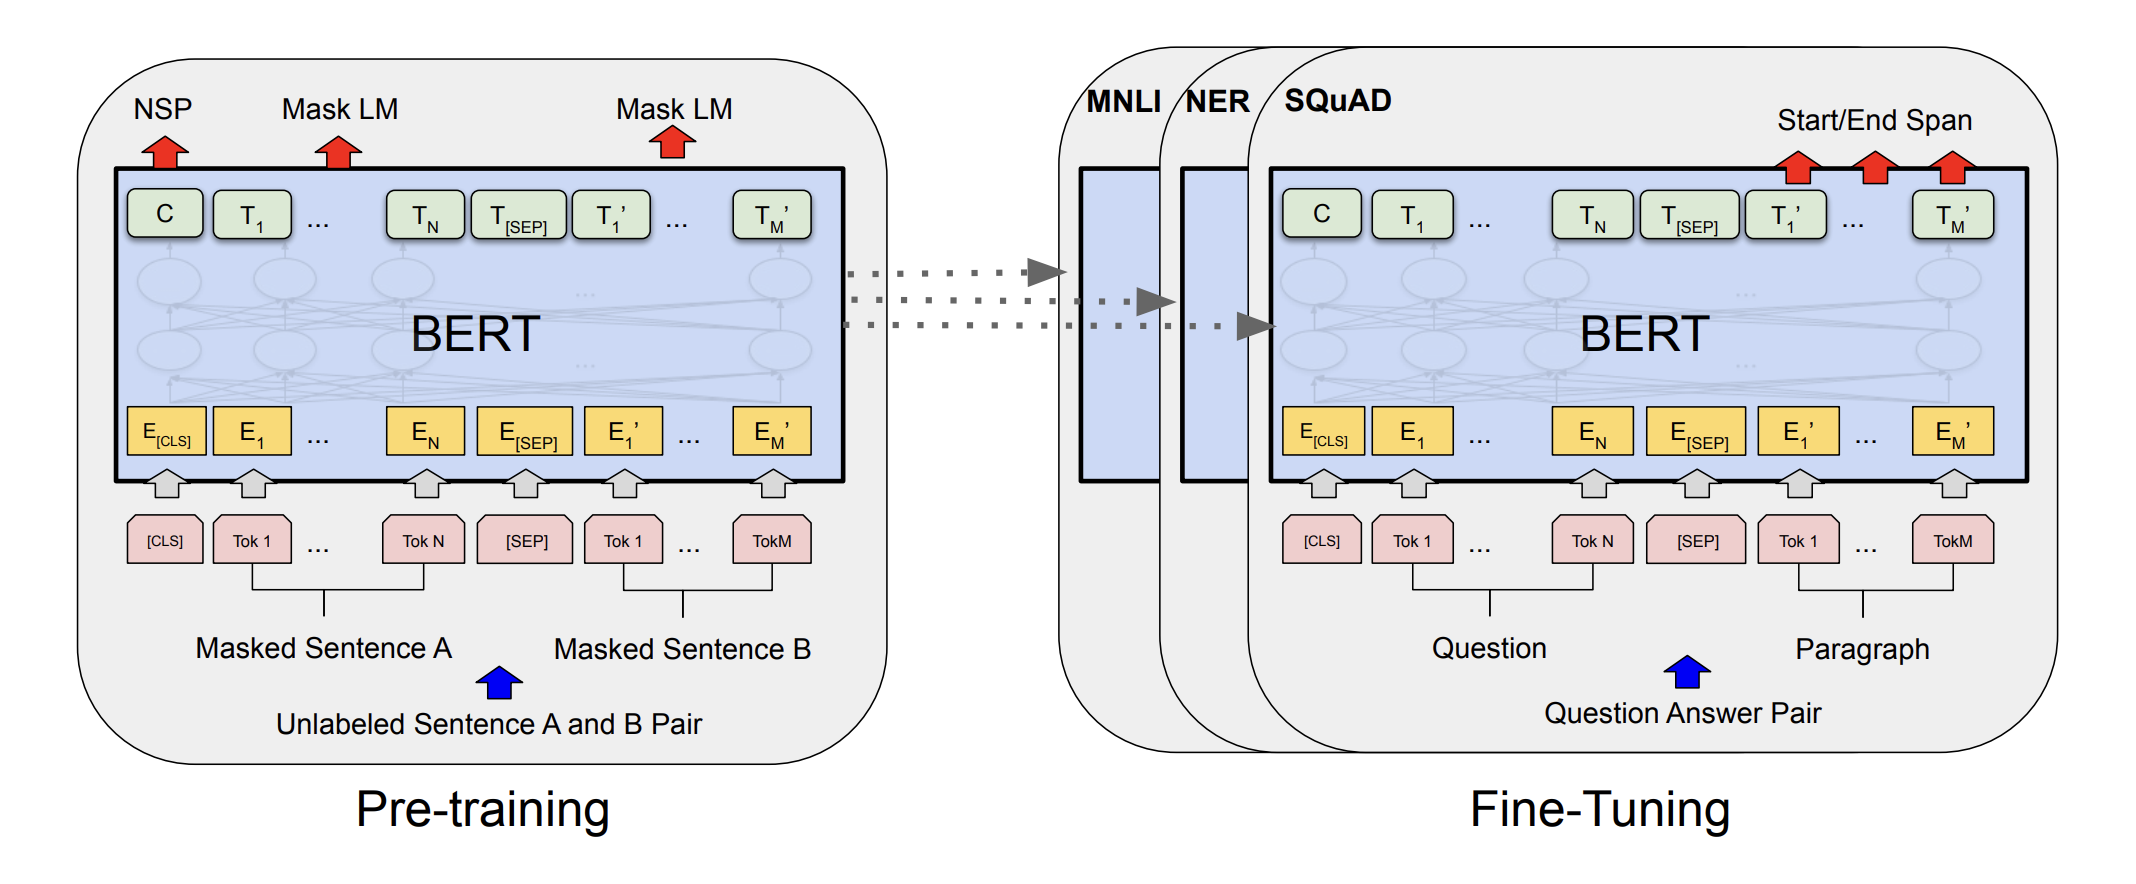

**BERT (Bidirectional Encoder Representations from Transformers)** is introduced by Google in 2018 (https://arxiv.org/abs/1810.04805). It is designed to pre-train language representations by leveraging the Transformer architecture, making it a powerful tool for a wide range of natural language processing (NLP) tasks.


**Key Features of BERT**

1. **Bidirectional Context**:
   - Unlike earlier models like GPT or traditional RNNs, BERT reads text both from left-to-right and right-to-left during training, capturing a deep understanding of context.
   - This bidirectional approach helps BERT better understand word meanings in context.

2. **Transformer Architecture**:
   - BERT is based on the Transformer encoder, which uses **self-attention** to capture relationships between words in a sequence, regardless of their distance.

3. **Pre-Training Tasks**:
   - **Masked Language Modeling (MLM)**:
     - Randomly masks words in the input and trains the model to predict them based on the surrounding context.
   - **Next Sentence Prediction (NSP)**:
     - Trains the model to understand the relationship between two sentences by predicting if the second sentence logically follows the first.


**Why is BERT so popular?**

1. **Transfer Learning**:
   - BERT can be fine-tuned on specific tasks like text classification, question answering, or named entity recognition, significantly reducing the need for large labeled datasets.

2. **Versatility**:
   - BERT can handle a wide variety of NLP tasks by adapting its pre-trained weights to downstream applications.


**Applications of BERT**

1. **Text Classification**:
   - Sentiment analysis, spam detection, or topic classification.
2. **Question Answering**:
   - Extractive QA systems like answering factual questions.
3. **Named Entity Recognition (NER)**:
   - Identifying entities like names, locations, or dates in text.
4. **Text Summarization**:
   - Both extractive and abstractive summarization.
5. **Machine Translation**:
   - Improving translation models by leveraging context-rich embeddings.
Please check here for [more introduction to NLP tasks](https://huggingface.co/tasks).



BERT has many variants. In this problem, we are going to reuse the multi-head attention from the problem 1 to impelemnt the DistillBert architecture, which is a knowledge distilled version of BERT with a smaller model size and faster training and inferencing speed.

In the problem 1, we have implemented multi-head attention. However, this is not the full story yet. If we look at the Transformer Encoder's diagram, we still miss some components to build the Transformer Encoder. But don't panic, the following code cells will guide you to implement a fully fucntional transformer encoder from scratch.

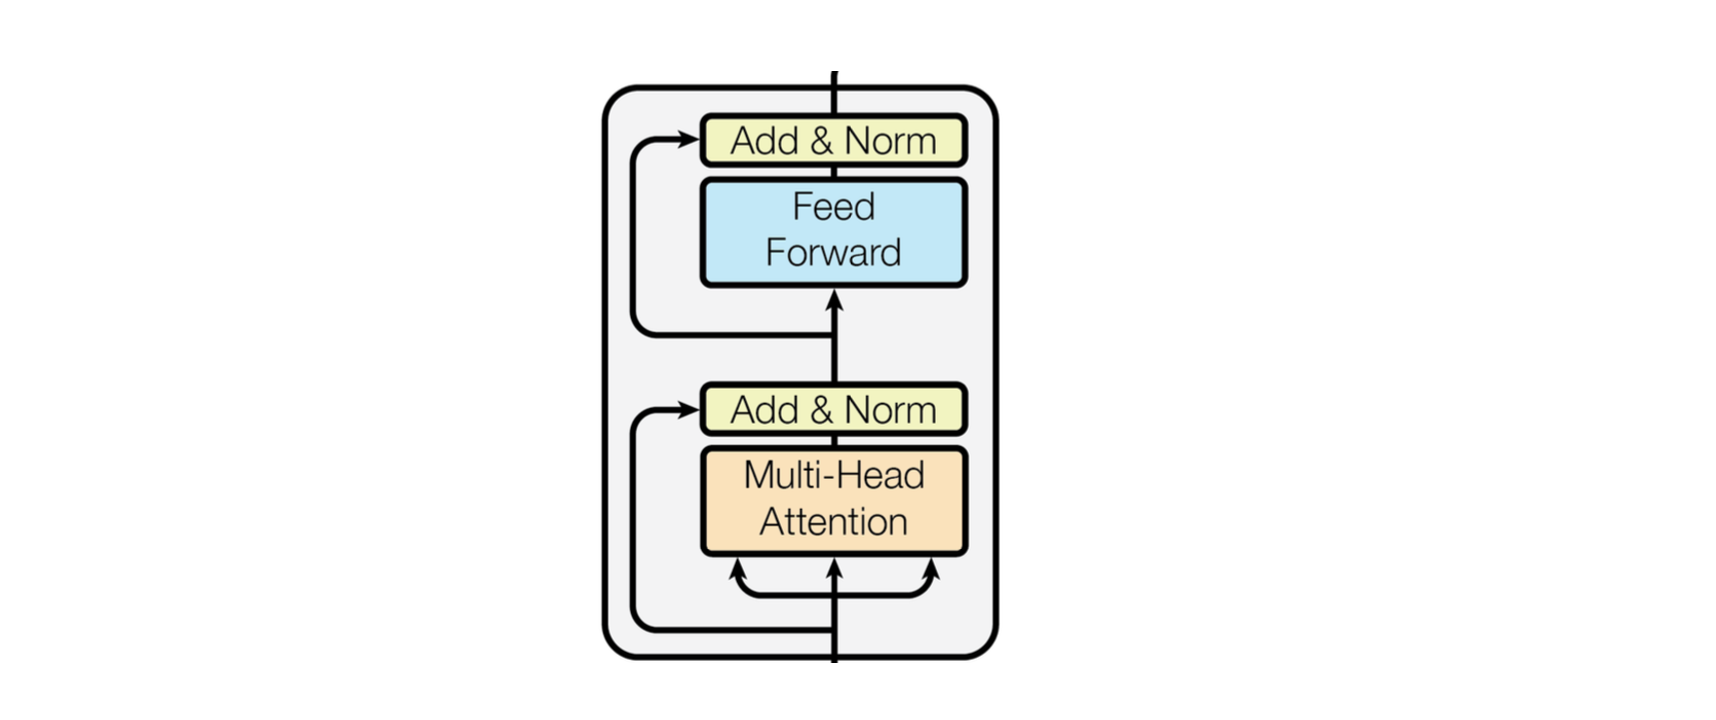

The first component we will implement is the **TransformerEncoderLayer**.

As depicted in the diagram above, the transformer encoder consists of two sub-layers:

1. **Multi-Head Self-Attention (MHSA) Sub-Layer**:  
   - The input hidden states are passed through a multi-head self-attention layer.  
   - This is followed by a residual connection and a layer normalization step.

2. **Feed-Forward Network (FFN) Sub-Layer**:  
   - The output hidden states from the first sub-layer are passed through a feed-forward network (FFN), also referred to as a multi-layer perceptron (MLP).  
   - This is followed by another residual connection and a layer normalization step.

Additionally, to prevent overfitting, we add dropout in the FFN.

In [4]:
import torch
import torch.nn as nn

# only single layer of the transformer encoder
class TransformerEncoderLayer(nn.Module):
    # Implement a single transformer encoder layer, ffn_expansion is the expansion factor for the feedforward network
    # For example, if hidden_size=512 and ffn_expansion=4, the feedforward network will be 512 -> 2048 -> 512
    def __init__(self, hidden_size, num_heads, dropout_prob, ffn_expansion=4, activation='gelu'):
        super(TransformerEncoderLayer, self).__init__()
        # TODO: Implement the transformer encoder layer
        # Multi-head self-attention layer
        # self.self_attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads, dropout=dropout_prob, batch_first=True)
        self.self_attention = Attention(hidden_size, num_heads, dropout_prob)

        # Feedforward network
        self.ffn = nn.Sequential(
            nn.Linear(hidden_size, ffn_expansion * hidden_size),
            nn.GELU() if activation == 'gelu' else nn.ReLU(),  # Activation function
            nn.Linear(ffn_expansion * hidden_size, hidden_size)
        )

        # Layer normalizations
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)

        # Dropout
        self.dropout = nn.Dropout(dropout_prob)


    def forward(self, hidden_states, mask=None, return_attention_weight=False):
        attention_weight = None
        # hidden_states: [batch_size, seq_len, hidden_size]
        # TODO: Implement the forward function
        # 1. Apply the multi-head attention
        # attn_output, attention_weight = self.self_attention(hidden_states, hidden_states, hidden_states, attn_mask=mask)
        attn_output, attention_weight = self.self_attention(hidden_states, mask, return_attention_weight)
        attn_output = self.dropout(attn_output)

        # 2. Apply the residual connection
        hidden_states = hidden_states + attn_output

        # 3. Apply the layer normalization
        hidden_states = self.norm1(hidden_states)

        # 4. Apply the feedforward network
        ffn_output = self.ffn(hidden_states)
        ffn_output = self.dropout(ffn_output)

        # 5. Apply the residual connection
        hidden_states = hidden_states + ffn_output

        # 6. Apply the layer normalization
        hidden_states = self.norm2(hidden_states)

        if return_attention_weight:
            return hidden_states, attention_weight
        return hidden_states

Next, we are going to build TransformerEncoder, which consists of num_layers of TransformerEncoderLayer.

In [5]:
# Combine multiple TransformerEncoderLayer to build a full encoder block
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, hidden_size, num_heads, dropout_prob, ffn_expansion=4):
        super(TransformerEncoder, self).__init__()
        # TODO: Initialize self.encoder_layers with num_layers TransformerEncoderLayer
        self.encoder_layers = nn.ModuleList([TransformerEncoderLayer(hidden_size, num_heads, dropout_prob, ffn_expansion) for _ in range(num_layers)])


    def forward(self, hidden_states, mask=None, return_attention_weight=False, return_all_hidden_states=False):
        # hidden_states: [batch_size, seq_len, hidden_size]
        # TODO Implement the forward function
        # List to store the hidden states from each layer if needed
        all_hidden_states = [] if return_all_hidden_states else None
        attention_weights = [] if return_attention_weight else None

        # # 1. Iterate through the encoder layers
        # for layer in self.encoder_layers:
        #     if return_attention_weight:
        #         hidden_states, attn_weight = layer(hidden_states, mask, return_attention_weight=True)
        #         if attention_weights is not None:
        #             attention_weights.append(attn_weight)
        #     else:
        #         hidden_states = layer(hidden_states, mask)

        #     # Store hidden states if requested
        #     if return_all_hidden_states:
        #         all_hidden_states.append(hidden_states)

        # # 2. Return the hidden states
        # if return_all_hidden_states and return_attention_weight:
        #     return all_hidden_states, attention_weights
        # elif return_all_hidden_states:
        #     return all_hidden_states
        # elif return_attention_weight:
        #     return hidden_states, attention_weights
        # else:
        #     return hidden_states

        for layer in self.encoder_layers:
            hidden_states, attention_weights = layer(hidden_states, mask, return_attention_weight=True)

            # Store all intermediate hidden states if required
            if return_all_hidden_states:
                all_hidden_states.append(hidden_states)

        if return_all_hidden_states:
            return all_hidden_states  # List of hidden states for each layer

        if return_attention_weight:
            return hidden_states, attention_weights  # Return final hidden states and attention weights
        return hidden_states  # Return final hidden states only

To represent texts into tokens, we usually tokenize the text into smaller units such as words, subwords, or characters using a tokenizer. Each token is then mapped to a numerical representation, often through an embedding layer, which transforms the tokens into dense vectors in a continuous vector space. These embeddings serve as the input to the Transformer model. The next code cell shows how to use tokenizer provided by Hugging Face transformers library.
Check out the visualization here (https://huggingface.co/spaces/Xenova/the-tokenizer-playground).

The tokenization can be visualized:


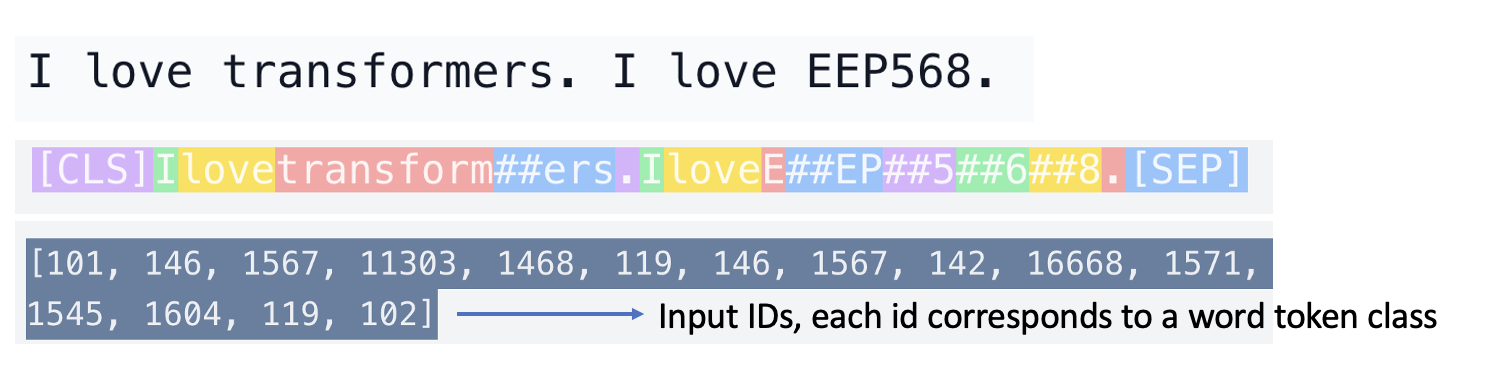

In [6]:
from transformers import DistilBertTokenizer
import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)
input_text = "I love transformers. I love EEP568."
max_len = 128
inputs = tokenizer.encode_plus(
    input_text,
    None,
    add_special_tokens=True,
    max_length=max_len,
    pad_to_max_length=True,
    return_token_type_ids=True,
    truncation=True
)
input_ids = torch.tensor(inputs['input_ids'], dtype=torch.long)
mask = inputs['attention_mask']
token_type_ids = inputs["token_type_ids"]

print(len(input_text))
print(input_ids.shape)
print(input_ids[:10])

input_text = "I love transformers. I love EEP568." * 1000
inputs = tokenizer.encode_plus(
    input_text,
    None,
    add_special_tokens=True,
    max_length=max_len,
    pad_to_max_length=True,
    return_token_type_ids=True,
    truncation=True

)
input_ids = torch.tensor(inputs['input_ids'], dtype=torch.long)
mask = inputs['attention_mask']
token_type_ids = inputs["token_type_ids"]

print(len(input_text))
print(input_ids.shape)
print(input_ids[:100])

# We can see that the encoded input are truncated to the max_len.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of th

35
torch.Size([128])
tensor([  101,  1045,  2293, 19081,  1012,  1045,  2293, 25212,  2361, 26976])
35000
torch.Size([128])
tensor([  101,  1045,  2293, 19081,  1012,  1045,  2293, 25212,  2361, 26976,
         2620,  1012,  1045,  2293, 19081,  1012,  1045,  2293, 25212,  2361,
        26976,  2620,  1012,  1045,  2293, 19081,  1012,  1045,  2293, 25212,
         2361, 26976,  2620,  1012,  1045,  2293, 19081,  1012,  1045,  2293,
        25212,  2361, 26976,  2620,  1012,  1045,  2293, 19081,  1012,  1045,
         2293, 25212,  2361, 26976,  2620,  1012,  1045,  2293, 19081,  1012,
         1045,  2293, 25212,  2361, 26976,  2620,  1012,  1045,  2293, 19081,
         1012,  1045,  2293, 25212,  2361, 26976,  2620,  1012,  1045,  2293,
        19081,  1012,  1045,  2293, 25212,  2361, 26976,  2620,  1012,  1045,
         2293, 19081,  1012,  1045,  2293, 25212,  2361, 26976,  2620,  1012])


Explanation of `tokenizer.encode_plus()` Parameters

**`input_text`**:
The input text, `"I love transformers."`, which will be tokenized.  
This text will be split into tokens based on the tokenizer’s vocabulary (e.g., subwords, words, or characters).


**`None`**:
This parameter is reserved for a second sentence (used for tasks like sentence-pair classification).  
Since this example processes only a single sentence, it’s set to `None`.

**`add_special_tokens=True`**:
Adds special tokens like `[CLS]` (start of sequence) and `[SEP]` (end of sequence or sentence separator).  
These tokens are required for models like BERT to understand the input.

**`max_length=max_len`**:
Specifies the maximum sequence length.  
In this case, the input will be truncated or padded to a length of 128 tokens.


**`pad_to_max_length=True`**:
Ensures that the sequence is padded to the `max_length` using the tokenizer’s padding token (e.g., `[PAD]`).

**`return_token_type_ids=True`**:
Returns token type IDs, which distinguish between different sentences in sentence-pair tasks:
- `0` for tokens from the first sentence.
- `1` for tokens from the second sentence.
- For single-sentence inputs, this will be all `0`s.

**`truncation=True`**:
Truncates the input sequence to fit within the specified `max_length` if it exceeds the limit.

For more details, please reference the [HF document](https://huggingface.co/docs/transformers/main_classes/tokenizer).

The last pieces of a BERT model are the word embedding layer and the positional embedding.

The word embedding layer is not a neural network layer but more like a learnable look-up table that maps input token IDs to feature vectors.

Since Transformers directly model the information flow between tokens and, unlike CNNs, do not process inputs sequentially (as CNNs use sliding convolutional kernels over input features), they lack an inherent sense of order or position in the input sequence. Therefore, we need to manually encode the positions of the input tokens.

In the **"Attention Is All You Need"** paper, this is achieved through **sinusoidal positional embeddings**, which encode the position of each token using sine and cosine functions with different wavelengths. This method ensures that the model can differentiate tokens based on their positions and capture both absolute and relative positional information effectively.

We will implement the positional embedding and word embedding layers in the `SimpleBert` class as part of the preprocessing steps. The positionally encoded input embeddings will then be passed to the transformer encoder for further processing.


In [7]:
# # implement the positional embedding and word embedding layers
# import torch
# import torch.nn as nn

# class SimpleBert(nn.Module):
#     def __init__(self, vocab_size, max_len, num_layers, hidden_size, num_heads, dropout_prob, ffn_expansion=4, pad_token_id=0):
#         super(SimpleBert, self).__init__()
#         # # TODO: Initialize the model with the following layers
#         # self.word_embeddings = nn.Embedding(vocab_size, hidden_size, padding_idx=pad_token_id)

#         # # Initialize positional embeddings explicitly
#         # self._init_positional_embeddings(max_len, hidden_size)
#         # self.positional_embeddings = nn.Parameter(self._init_positional_embeddings(max_len, hidden_size), requires_grad=False)
#         # self.encoder = TransformerEncoder(num_layers, hidden_size, num_heads, dropout_prob, ffn_expansion)
#         # self.layer_norm = nn.LayerNorm(hidden_size)
#         # self.dropout = nn.Dropout(dropout_prob)

#         # Word embeddings layer
#         self.word_embeddings = nn.Embedding(vocab_size, hidden_size, padding_idx=pad_token_id)

#         # Positional embeddings
#         self.positional_embeddings = nn.Embedding(max_len, hidden_size)

#         # Layer normalization and dropout
#         self.LayerNorm = nn.LayerNorm(hidden_size, eps=1e-12)
#         self.dropout = nn.Dropout(dropout_prob)

#         # Transformer encoder
#         self.encoder = TransformerEncoder(num_layers, hidden_size, num_heads, dropout_prob, ffn_expansion)

#         # Initialize positional embeddings
#         self._init_positional_embeddings(max_len, hidden_size)

#     def _init_positional_embeddings(self, max_len, hidden_size):
#         # TODO: Initialize sinusoidal positional embeddings.
#         pos_enc = torch.zeros(max_len, hidden_size)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, hidden_size, 2).float() * (-math.log(10000.0) / hidden_size))

#         pos_enc[:, 0::2] = torch.sin(position * div_term)
#         pos_enc[:, 1::2] = torch.cos(position * div_term)

#         return pos_enc.unsqueeze(0)  # Shape: [1, max_len, hidden_size]


#     def forward(self, input_ids, attention_mask):
#         # input_ids: [batch_size, seq_len]
#         # attention_mask: [batch_size, seq_len]
#         # TODO: Implement the forward function
#         # 1. Apply the word embedding
#         word_embeddings = self.word_embeddings(input_ids)  # Shape: [batch_size, seq_len, hidden_size]

#         # 2. Apply the positional embedding
#         seq_len = input_ids.size(1)
#         positional_embeddings = self.positional_embeddings[:, :seq_len, :]  # Shape: [1, seq_len, hidden_size]

#         # 3. Apply the layer normalization
#         embeddings = word_embeddings + positional_embeddings  # Shape: [batch_size, seq_len, hidden_size]
#         embeddings = self.layer_norm(embeddings)

#         # 4. Apply the dropout
#         embeddings = self.dropout(embeddings)
#         # 5. Apply the transformer encoder
#         output = self.encoder(embeddings, mask=attention_mask)

#         # 6. Return the output
#         return output

In [8]:
import torch
import torch.nn as nn

class SimpleBert(nn.Module):
    def __init__(self, vocab_size, max_len, num_layers, hidden_size, num_heads, dropout_prob, ffn_expansion=4, pad_token_id=0):
        super(SimpleBert, self).__init__()

        # Word embeddings layer
        self.word_embeddings = nn.Embedding(vocab_size, hidden_size, padding_idx=pad_token_id)

        # Positional embeddings
        self.positional_embeddings = nn.Embedding(max_len, hidden_size)

        # Layer normalization and dropout
        self.layer_norm = nn.LayerNorm(hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(dropout_prob)

        # Transformer encoder
        self.encoder = TransformerEncoder(num_layers, hidden_size, num_heads, dropout_prob, ffn_expansion)

        # Initialize positional embeddings
        self._init_positional_embeddings(max_len, hidden_size)

    def _init_positional_embeddings(self, max_len, hidden_size):
        # Initialize sinusoidal positional embeddings based on the original BERT paper.

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2) * (-math.log(10000.0) / hidden_size))
        pos_embedding = torch.zeros(max_len, hidden_size)
        pos_embedding[:, 0::2] = torch.sin(position * div_term)
        pos_embedding[:, 1::2] = torch.cos(position * div_term)
        self.positional_embeddings.weight.data = pos_embedding

    def forward(self, input_ids, attention_mask):
        # input_ids: [batch_size, seq_len]
        # attention_mask: [batch_size, seq_len]
        # TODO: Implement the forward function
        # 1. Apply the word embedding
        word_embeds = self.word_embeddings(input_ids)

        # 2. Apply the positional embedding
        seq_len = input_ids.size(1)
        position_ids = torch.arange(seq_len, device=input_ids.device).unsqueeze(0).expand_as(input_ids)
        pos_embeds = self.positional_embeddings(position_ids)

        # 3. Apply the layer normalization
        hidden_states = self.layer_norm(word_embeds + pos_embeds)

        # 4. Apply the dropout
        hidden_states = self.dropout(hidden_states)

        # Pass through the transformer encoder
        output = self.encoder(hidden_states, attention_mask)
        return output


Next, we are going to test our `SimpleBert` class by a dummy input.

In [9]:
# print device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
import math
# TODO: Define a simple BERT model with 30522 vocabulary size, 512 max sequence length, 6 layers, hidden size 768, 12 heads, and 0.1 dropout probability
model = SimpleBert(vocab_size=30522, max_len=512, num_layers=6, hidden_size=768, num_heads=12, dropout_prob=0.1)

# for key in model.state_dict():
#     print(key)

model

SimpleBert(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (positional_embeddings): Embedding(512, 768)
  (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (encoder): TransformerEncoder(
    (encoder_layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attention): Attention(
          (linear_q): Linear(in_features=768, out_features=768, bias=True)
          (linear_k): Linear(in_features=768, out_features=768, bias=True)
          (linear_v): Linear(in_features=768, out_features=768, bias=True)
          (linear_out): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ffn): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (norm1): LayerNorm((768,), eps=1e-05, 

In [40]:

# import torch
# torch.cuda.empty_cache()

In [12]:
import math
# TODO: Define a simple BERT model with 30522 vocabulary size, 512 max sequence length, 6 layers, hidden size 768, 12 heads, and 0.1 dropout probability
model = SimpleBert(vocab_size=30522, max_len=512, num_layers=6, hidden_size=768, num_heads=12, dropout_prob=0.1)
model = model.cuda()

# TODO Define the input_ids tensor with batch size 2 and sequence length 128
input_ids = torch.randint(0, 30522, (2, 128)).to(device)

# TODO Define a full attention mask tensor with shape [2, 128]
attention_mask = torch.ones(2, 128).to(device)

model.eval()
with torch.no_grad():
    output1 = model(input_ids, attention_mask)
print(output1.shape)

torch.Size([2, 128, 768])


You did it!

Next, we want to load the `DistilBertModel` model with pretrained weight from the Hugging Face.
The `DistilBertModel` should have the same output shape as `SimpleBert`'s output.

In [13]:
from transformers import DistilBertModel

model = DistilBertModel.from_pretrained("distilbert-base-uncased")
model = model.cuda()
model.eval()
with torch.no_grad():
    output2 = model(input_ids, attention_mask)
print(output2.last_hidden_state.shape)

torch.Size([2, 128, 768])


Great! The `DistilBertModel` has the same output shape as our `SimpleBert`.  

Next, we want to initialize our `SimpleBert` with the model weights from `DistilBertModel`.  
In modern machine learning, it is crucial to learn how to map model weights between different implementations, as different libraries often use varying module naming conventions or implementation details. Mastering model weight conversion allows you to leverage pretrained weights from one platform or library and adapt them to another.  

The most basic approach to model weight conversion is to implement a lookup table that maps the module names between the two models. In the following function, we will implement a weight mapping function to achieve this.


In [14]:
def map_weights(hf_state_dict, custom_model_state_dict, num_layers):
    key_mapping = {
        "embeddings.word_embeddings.weight": "word_embeddings.weight",
        "embeddings.position_embeddings.weight": "positional_embeddings.weight",
        "embeddings.LayerNorm.weight": "layer_norm.weight",
        "embeddings.LayerNorm.bias": "layer_norm.bias",
    }

    for i in range(num_layers):
        key_mapping.update({
            f"transformer.layer.{i}.attention.q_lin.weight": f"encoder.encoder_layers.{i}.self_attention.linear_q.weight",
            f"transformer.layer.{i}.attention.q_lin.bias": f"encoder.encoder_layers.{i}.self_attention.linear_q.bias",
            f"transformer.layer.{i}.attention.k_lin.weight": f"encoder.encoder_layers.{i}.self_attention.linear_k.weight",
            f"transformer.layer.{i}.attention.k_lin.bias": f"encoder.encoder_layers.{i}.self_attention.linear_k.bias",
            f"transformer.layer.{i}.attention.v_lin.weight": f"encoder.encoder_layers.{i}.self_attention.linear_v.weight",
            f"transformer.layer.{i}.attention.v_lin.bias": f"encoder.encoder_layers.{i}.self_attention.linear_v.bias",
            f"transformer.layer.{i}.attention.out_lin.weight": f"encoder.encoder_layers.{i}.self_attention.linear_out.weight",
            f"transformer.layer.{i}.attention.out_lin.bias": f"encoder.encoder_layers.{i}.self_attention.linear_out.bias",
            f"transformer.layer.{i}.sa_layer_norm.weight": f"encoder.encoder_layers.{i}.norm1.weight",
            f"transformer.layer.{i}.sa_layer_norm.bias": f"encoder.encoder_layers.{i}.norm1.bias",
            f"transformer.layer.{i}.ffn.lin1.weight": f"encoder.encoder_layers.{i}.ffn.0.weight",
            f"transformer.layer.{i}.ffn.lin1.bias": f"encoder.encoder_layers.{i}.ffn.0.bias",
            f"transformer.layer.{i}.ffn.lin2.weight": f"encoder.encoder_layers.{i}.ffn.2.weight",
            f"transformer.layer.{i}.ffn.lin2.bias": f"encoder.encoder_layers.{i}.ffn.2.bias",
            f"transformer.layer.{i}.output_layer_norm.weight": f"encoder.encoder_layers.{i}.norm2.weight",
            f"transformer.layer.{i}.output_layer_norm.bias": f"encoder.encoder_layers.{i}.norm2.bias",
        })

    new_state_dict = {}
    for hf_key, custom_key in key_mapping.items():
        if hf_key in hf_state_dict and custom_key in custom_model_state_dict:
            new_state_dict[custom_key] = hf_state_dict[hf_key]
        else:
            print(f"Warning: Key {hf_key} or {custom_key} not found in the state dictionaries.")

    return new_state_dict


def load_model_weight_from_hf_pretrained(simple_bert_model, pretrained_model_state_dict):
    # Load the simple bert model state dictionary
    simple_bert_model_state_dict = simple_bert_model.state_dict()
    # Map the weights from the pretrained model to the simple bert model
    mapped_weights = map_weights(pretrained_model_state_dict, simple_bert_model_state_dict, num_layers=len(simple_bert_model.encoder.encoder_layers))
    # Load the mapped weights to the simple bert model
    missing_keys, unexpected_keys =  simple_bert_model.load_state_dict(mapped_weights, strict=False)
    print(f"Missing keys: {missing_keys}")
    print(f"Unexpected keys: {unexpected_keys}")

Let us load the pretrained weight from the Huggingface's DistilBert. Run the forward pass for our SimpleBert and the DistillBert and compare the results. The results from both model should be identical.

In [15]:
# Load the pretrained model
model = DistilBertModel.from_pretrained("distilbert-base-uncased")
pretrained_model_state_dict = model.state_dict()
model = model.cuda()
model.eval()
with torch.no_grad():
    output2 = model(input_ids, attention_mask)
print(output2.last_hidden_state.shape)
# print(output2.last_hidden_state)


# TODO: Define a simple BERT model with 30522 vocabulary size, 512 max sequence length, 6 layers, hidden size 768, 12 heads, and 0.1 dropout probability
model = SimpleBert(vocab_size=30522, max_len=512, num_layers=6, hidden_size=768, num_heads=12, dropout_prob=0.1)
load_model_weight_from_hf_pretrained(model, pretrained_model_state_dict)
model = model.cuda()
model.eval()
with torch.no_grad():
    output1 = model(input_ids, attention_mask)
print(output1.shape)
# print(output1)

print(torch.allclose(output1, output2.last_hidden_state, atol=1e-3)) # This should return True. False means the outputs are not consistent.


torch.Size([2, 128, 768])
Missing keys: []
Unexpected keys: []
torch.Size([2, 128, 768])
True


Congradulations! It's a big milestone.

Next, we are going to implement a sequence classification model using our `SimpleBert` model.
Since our `SimpleBert` is initialized with pre-trained weight. According to the BERT paper, it can be easily fine-tuned to many natural language processing (NLP) tasks.

**Sequence classification** is a fundamental task in natural language processing (NLP) where the goal is to assign a single label or category to an entire sequence of text. This could involve predicting the sentiment of a sentence, determining the topic of a document, or identifying whether an email is spam or not.


Key Features of Sequence Classification

1. **Input**:  
   The input is typically a sequence of text (e.g., a sentence, paragraph, or document). The text is tokenized into smaller units such as words or subwords before being processed by a model.

2. **Output**:  
   The output is a single label or a probability distribution over multiple classes, depending on the nature of the classification task.


First, let's implement `BertForSequenceClassification` for the text classification task.

Creating the Neural Network for Fine Tuning

 - We will be creating a neural network with the `BertForSequenceClassification` class.
 - This network will have the `SimpleBert` model.  Follwed by a `Droput` and `Linear Layer`. They are added for the purpose of **Regulariaztion** and **Classification** respectively.
- We use the first token's output hidden states as the input to the fully connect layer for classification
 - Keep note the number of dimensions for `Linear Layer` is **1** because that is the total number of categories in which we are looking to classify our model (A sentence positive or negative).
 - The data will be fed to the `BertForSequenceClassification` as defined in the dataset.
 - We will initiate an instance of the network called `model`. This instance will be used for training and then to save the final trained model for future inference.



In [18]:
import torch
import torch.nn as nn

class BertForSequenceClassification(nn.Module):
    def __init__(self, num_classes, vocab_size, max_len, num_layers, hidden_size, num_heads, dropout_prob, ffn_expansion=4, pad_token_id=0):
        super(BertForSequenceClassification, self).__init__()
        self.bert = SimpleBert(vocab_size, max_len, num_layers, hidden_size, num_heads, dropout_prob, ffn_expansion, pad_token_id)
        # fc
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, input_ids, attention_mask=None):
        # Pass through the BERT model (SimpleBert)
        output = self.bert(input_ids, attention_mask)

        # Use the first token's output (CLS token) for classification
        cls_output = output[:, 0, :]  # Shape: [batch_size, hidden_size]

        # Pass through the fully connected layer
        output = self.fc(cls_output)  # Shape: [batch_size, num_classes]

        return output

For this sequence classification task, we will be working on [Stanford Sentiment Treebank](https://huggingface.co/datasets/stanfordnlp/sst2).

The Stanford Sentiment Treebank is a corpus with fully labeled parse trees that allows for a complete analysis of the compositional effects of sentiment in language. The corpus is based on the dataset introduced by [Pang and Lee (2005)](https://nlp.stanford.edu/sentiment/) and consists of 11,855 single sentences extracted from movie reviews. It was parsed with the Stanford parser and includes a total of 215,154 unique phrases from those parse trees, each annotated by 3 human judges.

Binary classification experiments on full sentences (negative or somewhat negative vs somewhat positive or positive with neutral sentences discarded) refer to the dataset as SST-2 or SST binary.

 Importing and Pre-Processing the Stanford Sentiment Treebank dataset

In [19]:
# !pip install datasets

In [20]:
from datasets import load_dataset
sst2_ds = load_dataset('stanfordnlp/sst2')
sst2_sample = sst2_ds['train'].select(range(1000))
# Visualizing the dataset samples
print(sst2_sample.to_pandas().head())

   idx                                           sentence  label
0    0       hide new secretions from the parental units       0
1    1               contains no wit , only labored gags       0
2    2  that loves its characters and communicates som...      1
3    3  remains utterly satisfied to remain the same t...      0
4    4  on the worst revenge-of-the-nerds clichés the ...      0


Preparing the Dataset and Dataloader

We will start with defining few key variables that will be used later during the training/fine tuning stage.
Followed by creation of MultiLabelDataset class - This defines how the text is pre-processed before sending it to the neural network. We will also define the Dataloader that will feed  the data in batches to the neural network for suitable training and processing.
Dataset and Dataloader are constructs of the PyTorch library for defining and controlling the data pre-processing and its passage to neural network. For further reading into Dataset and Dataloader read the [docs at PyTorch](https://pytorch.org/docs/stable/data.html)

**MultiLabelDataset** Dataset Class
- This class is defined to accept the `tokenizer`, `dataframe` and `max_length` as input and generate tokenized output and tags that is used by the BERT model for training.
- We are using the DistilBERT tokenizer to tokenize the data in the `text` column of the dataframe.
- The tokenizer uses the `encode_plus` method to perform tokenization and generate the necessary outputs, namely: `ids`, `attention_mask`, `token_type_ids`

- To read further into the tokenizer, [refer to this document](https://huggingface.co/transformers/model_doc/distilbert.html#distilberttokenizer)
- `targets` is the list of categories labled as `0` or `1` in the dataframe.
- The *MultiLabelDataset* class is used to create 2 datasets, for training and for validation.


Dataloader
- Dataloader is used to for creating training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, hence the amount of dataloaded to the memory and then passed to the neural network needs to be controlled.
- This control is achieved using the parameters such as `batch_size` and `max_len`.
- Training and Validation dataloaders are used in the training and validation part of the flow respectively

In [21]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 128
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 128
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

For the test samples, the labels are -1, because we don't know the groundtruth.

In [22]:

sst2_sample = sst2_ds['train'].select(range(100))
# Visualizing the dataset samples
print("Training samples")
print(sst2_sample.to_pandas().head())
print('\n')
sst2_sample = sst2_ds['validation'].select(range(10))
# Visualizing the dataset samples
print("Validation samples")
print(sst2_sample.to_pandas().head())
print('\n')
sst2_sample = sst2_ds['test'].select(range(10))
# Visualizing the dataset samples
print("Test samples")
print(sst2_sample.to_pandas().head())

Training samples
   idx                                           sentence  label
0    0       hide new secretions from the parental units       0
1    1               contains no wit , only labored gags       0
2    2  that loves its characters and communicates som...      1
3    3  remains utterly satisfied to remain the same t...      0
4    4  on the worst revenge-of-the-nerds clichés the ...      0


Validation samples
   idx                                           sentence  label
0    0    it 's a charming and often affecting journey .       1
1    1                 unflinchingly bleak and desperate       0
2    2  allows us to hope that nolan is poised to emba...      1
3    3  the acting , costumes , music , cinematography...      1
4    4                  it 's slow -- very , very slow .       0


Test samples
   idx                                           sentence  label
0    0             uneasy mishmash of styles and genres .     -1
1    1  this film 's relationship to 

In [23]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch import tensor

class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.sentence = dataframe.sentence
        self.targets = self.data.label
        self.max_len = max_len

    def __len__(self):
        return len(self.sentence)

    def __getitem__(self, index):
        sentence = str(self.sentence[index])
        sentence = " ".join(sentence.split())

        # # TODO: encode the sentence using self.tokenizer
        # input = self.tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=self.max_len, padding='max_length', truncation=True, return_tensors='pt')

        # # TODO: return the necessary data fields
        # return {
        #     'ids': inputs['input_ids'].flatten(),
        #     'mask': inputs['attention_mask'].flatten(),
        #     'token_type_ids': inputs.get('token_type_ids', torch.tensor([0] * self.max_len)),
        #     'targets': torch.tensor(self.targets[index], dtype=torch.long)
        # }
        inputs = self.tokenizer.encode_plus(
            sentence,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt'  # Ensure the output is a tensor
        )

        # Get input_ids, attention_mask, and token_type_ids
        input_ids = inputs['input_ids'].squeeze(0)  # Remove the extra batch dimension
        attention_mask = inputs['attention_mask'].squeeze(0)
        token_type_ids = inputs.get('token_type_ids', torch.zeros_like(input_ids))  # Default to zeros if not present

        # Get the target label
        target = self.targets[index]

        return {
            'ids': input_ids,
            'mask': attention_mask,
            'token_type_ids': token_type_ids,
            'targets': torch.tensor(target, dtype=torch.long)  # Ensure the target is a tensor
        }

In [24]:
# Creating the dataset and dataloader for the neural network

training_set = sst2_ds['train'].to_pandas()
val_set = sst2_ds['validation'].to_pandas()

print("TRAIN Dataset: {}".format(training_set.shape))
print("VAL Dataset: {}".format(val_set.shape))

training_set = MultiLabelDataset(training_set, tokenizer, MAX_LEN)
val_set = MultiLabelDataset(val_set, tokenizer, MAX_LEN)

TRAIN Dataset: (67349, 3)
VAL Dataset: (872, 3)


In [25]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
val_loader = DataLoader(val_set, **train_params)

Loss Function and Optimizer
 - The Loss is defined in the next cell as `loss_fn`.
 - As defined above, the loss function used will be a combination of Binary Cross Entropy which is implemented as [BCELogits Loss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) in PyTorch
 - `Optimizer` is defined in the next cell.
 - `Optimizer` is used to update the weights of the neural network to improve its performance.

In [26]:
from torch import cuda
import torch.nn as nn
import torch.optim as optim
device = 'cuda' if cuda.is_available() else 'cpu'

# model = BertForSequenceClassification().to('device')
model = BertForSequenceClassification(
    num_classes=1,
    vocab_size=30522,
    max_len=MAX_LEN,
    num_layers=6,
    hidden_size=768,
    num_heads=12,
    dropout_prob=0.1
).to(device)

optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# TODO: define the loss function (nn.BCEWithLogitsLoss)
def loss_fn(outputs, targets):
    # TODO: return the loss function
    targets = targets.view(-1, 1)  # Reshape to [batch_size, 1]
    return nn.BCEWithLogitsLoss()(outputs, targets.float())


# def loss_fn(outputs, targets):
#     # Ensure targets are of shape [batch_size, num_classes]
#     if len(targets.shape) > 1:
#       targets = targets.squeeze(1)  # Remove the second dimension if it exists

#     # Convert targets to the right shape for BCEWithLogitsLoss
#     targets_one_hot = torch.zeros_like(outputs)
#     targets_one_hot[torch.arange(len(targets)), targets] = 1  # One-hot encode the target

#     # Return the BCE loss
#     return nn.BCEWithLogitsLoss()(outputs, targets_one_hot.float())

In [27]:
from tqdm import tqdm
import numpy as np

def validation(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    decision_boundary = 0.5
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask)
            fin_targets.extend(targets.cpu().detach().numpy().flatten().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).flatten().cpu().detach().numpy().tolist())

    acc = round(np.sum( ((np.array(fin_outputs) > decision_boundary).astype(np.float32)) == np.array(fin_targets))/len(fin_outputs), 2)

    return fin_outputs, fin_targets, acc

In [28]:

# # TODO: implement the training loop
# def train(epoch, model, optimizer):
#     model.train()
#     for training_iter, data in tqdm(enumerate(training_loader, 0)):
#         # TODO: Implement the training loop, calculate the loss and update the model weights which is the same as image classification training workflow implemented in previous homework

#         if training_iter % 100==0: # Log every 100 iterations
#             _, _, val_acc = validation(val_loader)
#             print(f'Epoch: {epoch}, Loss:  {loss.item()}, Val acc:  {val_acc}')

def train(epoch, model, optimizer):
    model.train()  # Set model to training mode
    total_train_loss = 0

    for training_iter, data in tqdm(enumerate(training_loader, 0)):
        # Get data and move to the GPU
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(ids, mask)

        # Calculate the loss
        loss = loss_fn(outputs, targets)
        total_train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        if training_iter % 100 == 0:  # Log every 100 iterations
            _, _, val_acc = validation(val_loader)  # Compute validation accuracy
            print(f'Epoch: {epoch}, Iteration: {training_iter}, Loss: {loss.item()}, Val Acc: {val_acc}')

    # Print the average training loss for this epoch
    print(f"Epoch {epoch + 1} - Training Loss: {total_train_loss / len(training_loader)}")



In [41]:
# # Training the model
# for epoch in range(EPOCHS):
#     train(epoch, model, optimizer)



# if we did not load pre-trained weight to train the model, the accuracy is at most 0.75.
# loading pre-trained weight method is down below

Validating the Model

During the validation stage we pass the validation data to the model. This step determines how good the model performs on the unseen data.

You should achieve over 90% for the classification accuracy on the validation data.

In [39]:
# import torch
# torch.cuda.empty_cache()

In [31]:
def train(epoch, model, optimizer):
    model.train()  # Set model to training mode
    total_train_loss = 0

    for training_iter, data in tqdm(enumerate(training_loader, 0)):
        # Get data and move to the GPU
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(ids, mask)
        logits = outputs.logits

        # Calculate the loss
        # loss = loss_fn(outputs, targets)
        loss = loss_fn(logits, targets)
        total_train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        if training_iter % 100 == 0:  # Log every 100 iterations
            _, _, val_acc = validation(val_loader)  # Compute validation accuracy
            print(f'Epoch: {epoch}, Iteration: {training_iter}, Loss: {loss.item()}, Val Acc: {val_acc}')

    # Print the average training loss for this epoch
    print(f"Epoch {epoch + 1} - Training Loss: {total_train_loss / len(training_loader)}")

In [32]:
from tqdm import tqdm
import numpy as np

def validation(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    decision_boundary = 0.5
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(ids, mask)
            logits = outputs.logits

            # fin_targets.extend(targets.cpu().detach().numpy().flatten().tolist())
            # fin_outputs.extend(torch.sigmoid(outputs).flatten().cpu().detach().numpy().tolist())

            fin_outputs.extend(torch.sigmoid(logits).flatten().cpu().detach().numpy().tolist())
            fin_targets.extend(targets.cpu().detach().numpy().flatten().tolist())

    acc = round(np.sum( ((np.array(fin_outputs) > decision_boundary).astype(np.float32)) == np.array(fin_targets))/len(fin_outputs), 2)

    return fin_outputs, fin_targets, acc

In [33]:

from transformers import DistilBertForSequenceClassification
import torch

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1).to(device)

optimizer = optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

# Training loop
for epoch in range(EPOCHS):
    train(epoch, model, optimizer)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.38it/s]
2it [00:01,  1.54it/s]
3it [00:01,  1.54it/s]
4it [00:02,  1.55it/s]
5it [00:03,  1.38it/s]
6it [00:04,  1.41it/s]
7it [00:04,  1.48it/s]
1it [00:06,  6.06s/it]

Epoch: 0, Iteration: 0, Loss: 0.6873924732208252, Val Acc: 0.51


100it [01:58,  1.14s/it]
0it [00:00, ?it/s]
1it [00:01,  1.12s/it]
2it [00:01,  1.29it/s]
3it [00:02,  1.50it/s]
4it [00:02,  1.61it/s]
5it [00:03,  1.68it/s]
6it [00:03,  1.71it/s]
7it [00:04,  1.62it/s]
101it [02:03,  2.44s/it]

Epoch: 0, Iteration: 100, Loss: 0.2763989269733429, Val Acc: 0.87


200it [03:55,  1.13s/it]
0it [00:00, ?it/s]
1it [00:01,  1.12s/it]
2it [00:01,  1.28it/s]
3it [00:02,  1.49it/s]
4it [00:02,  1.61it/s]
5it [00:03,  1.69it/s]
6it [00:03,  1.74it/s]
7it [00:04,  1.64it/s]
201it [04:00,  2.42s/it]

Epoch: 0, Iteration: 200, Loss: 0.2893238067626953, Val Acc: 0.88


300it [05:51,  1.13s/it]
0it [00:00, ?it/s]
1it [00:01,  1.11s/it]
2it [00:01,  1.28it/s]
3it [00:02,  1.48it/s]
4it [00:02,  1.61it/s]
5it [00:03,  1.67it/s]
6it [00:03,  1.71it/s]
7it [00:04,  1.65it/s]
301it [05:57,  2.41s/it]

Epoch: 0, Iteration: 300, Loss: 0.2048695683479309, Val Acc: 0.9


400it [07:48,  1.13s/it]
0it [00:00, ?it/s]
1it [00:01,  1.11s/it]
2it [00:01,  1.29it/s]
3it [00:02,  1.51it/s]
4it [00:02,  1.62it/s]
5it [00:03,  1.67it/s]
6it [00:03,  1.79it/s]
7it [00:04,  1.68it/s]
401it [07:53,  2.38s/it]

Epoch: 0, Iteration: 400, Loss: 0.09478524327278137, Val Acc: 0.89


500it [09:44,  1.13s/it]
0it [00:00, ?it/s]
1it [00:01,  1.12s/it]
2it [00:01,  1.29it/s]
3it [00:02,  1.48it/s]
4it [00:02,  1.60it/s]
5it [00:03,  1.66it/s]
6it [00:03,  1.77it/s]
7it [00:04,  1.66it/s]
501it [09:50,  2.40s/it]

Epoch: 0, Iteration: 500, Loss: 0.112984798848629, Val Acc: 0.9


527it [10:18,  1.17s/it]

Epoch 1 - Training Loss: 0.25721345526613365


In [34]:
outputs, targets, acc = validation(val_loader)
print(f'Accuracy: {acc}')

final_outputs = np.array(outputs) >=0.5

7it [00:03,  2.15it/s]

Accuracy: 0.9


In [37]:
# Randomly select the 10 test data and print the inference results
test_data = sst2_ds['test'].to_pandas().sample(10, random_state=568).reset_index(drop=True)
print(test_data)
test_loader = DataLoader(MultiLabelDataset(test_data, tokenizer, MAX_LEN), **test_params)

decision_boundary = 0.5
model.eval()
fin_targets = []
fin_outputs = []
with torch.no_grad():
    for _, data in tqdm(enumerate(test_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        # outputs = model(ids, mask)
        # fin_outputs.extend((torch.sigmoid(outputs).flatten().cpu().detach() > 0.5).to(torch.int).tolist())

        outputs = model(ids, mask)
        logits = outputs.logits
        fin_outputs.extend((torch.sigmoid(logits).flatten().cpu().detach() > 0.5).to(torch.int).tolist())
print('\n')
for i in range(10):
    print(f"Data: {test_data['sentence'][i]}")
    print(f"Prediction: {fin_outputs[i]}")

    idx                                           sentence  label
0  1204  scarlet diva has a voyeuristic tug , but all i...     -1
1   158  this concoction , so bizarre to the adult mind...     -1
2  1070  lead provocatuers testud and parmentier give s...     -1
3  1218  the values that have held the enterprise crew ...     -1
4  1517  this series should have died long ago , but th...     -1
5    74  a mawkish , implausible platonic romance that ...     -1
6  1489  for me , this opera is n't a favorite , so it ...     -1
7  1741  mocking them now is an exercise in pointlessne...     -1
8  1430  a miniscule little bleep on the film radar , b...     -1
9   191  apparently kissing leads to suicide attempts a...     -1


1it [00:00, 16.09it/s]



Data: scarlet diva has a voyeuristic tug , but all in all it 's a lot less sensational than it wants to be .
Prediction: 0
Data: this concoction , so bizarre to the adult mind , is actually a charming triumph where its intended under-12 audience is concerned .
Prediction: 1
Data: lead provocatuers testud and parmentier give superlative performances
Prediction: 0
Data: the values that have held the enterprise crew together through previous adventures and perils do so again-courage , self-sacrifice and patience under pressure .
Prediction: 1
Data: this series should have died long ago , but they keep bringing it back another day as punishment for paying money to see the last james bond movie .
Prediction: 0
Data: a mawkish , implausible platonic romance that makes chaplin 's city lights seem dispassionate by comparison .
Prediction: 0
Data: for me , this opera is n't a favorite , so it 's a long time before the fat lady sings .
Prediction: 1
Data: mocking them now is an exercise in poi

**Answer the following questions:**

**Q: Why people use layer norm instead of batch norm in Transformer?**

**Ans:** Layer normalization is preferred because it normalizes the data for each individual sample, not across the batch, which helps with variable sequence lengths. Batch normalization relies on statistics across the batch, but this can be less effective when sequences vary in length or when processing long sequences. In addition, layer normalization works well in models with variable batch sizes and is more stable for sequential data processing, which is common in transformers.

**Q: Besides sinusoidal positional encoding, can you list two more positional encoding techniques?**



| Positional Encoding Name | How it works | Method Origin (paper or website's link) |
|----------|----------|----------|
|       Example: Sinusoidal positional encoding   |     Adding continuous and periodic functions (sine and cosine) to the input embeddings.     |      https://arxiv.org/abs/1706.03762    |
| 1.     Relative positional encoding    |      Capturing how far apart tokens are from each other in a sequence and uses that information in the model's attention.    |      https://arxiv.org/abs/1803.02155    |
| 2.      Learnable positional encoding   |     The model learns a unique positional encoding for each position during training, rather than using a fixed encoding, allowing it to adjust based on the specific task.     |     https://arxiv.org/abs/1706.03762     |


